# Imports

In [1]:
import time
import math
import random
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt, gridspec
plt.switch_backend('agg')
from torch.nn import Parameter
from torch.autograd import Variable
import numpy as np
import torch
from torch import matmul
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from attention_model_helper import input_lang, output_lang, pairs, indexesFromSentence, timeSince, showPlot

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SOS_token = 0
EOS_token = 1

MAX_LENGTH = 10

print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['elle l a regarde droit dans les yeux .', 'she stared him in the face .']


In [22]:
def _getGRUWeights(di, dj):
    _W = torch.Tensor(di, dj)
    _W = Variable(torch.nn.init.xavier_normal_(_W).cuda(), requires_grad=True)
    return _W

def _getGRUbias(d):
    _b = torch.Tensor(d)
    _b = Variable(torch.nn.init.normal_(_b).cuda(), requires_grad=True)
    return _b

In [2]:
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [45]:
# Training
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, use_attention, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    for di in range(target_length):
        if use_attention:
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
        else:
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  # detach from history as input

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [46]:
# Training
def trainIters(encoder, decoder, n_iters, use_attention, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, use_attention)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
    return plot_losses

In [47]:
# Evaluation
def evaluate(encoder, decoder, sentence, use_attention, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        if use_attention:
            decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            if use_attention:
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                decoder_attentions[di] = decoder_attention.data
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
        
        if use_attention:
            return decoded_words, decoder_attentions[:di + 1]
        else:
            return decoded_words


In [54]:
# Evaluation
def evaluateRandomly(encoder, decoder, use_attention, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        if use_attention:
            output_words, attentions = evaluate(encoder, decoder, pair[0], use_attention)
        else:
            output_words = evaluate(encoder, decoder, pair[0], use_attention)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

# Model I: Torch RNN

In [103]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

1m 6s (- 15m 33s) (5000 6%) 3.0552
2m 11s (- 14m 14s) (10000 13%) 2.5031
3m 16s (- 13m 6s) (15000 20%) 2.1788
4m 21s (- 12m 0s) (20000 26%) 1.9104
5m 27s (- 10m 54s) (25000 33%) 1.7247
6m 33s (- 9m 49s) (30000 40%) 1.5261
7m 38s (- 8m 44s) (35000 46%) 1.3543
8m 44s (- 7m 38s) (40000 53%) 1.2199
9m 50s (- 6m 33s) (45000 60%) 1.0865
10m 56s (- 5m 28s) (50000 66%) 0.9908
12m 3s (- 4m 22s) (55000 73%) 0.9138
13m 9s (- 3m 17s) (60000 80%) 0.8424
14m 15s (- 2m 11s) (65000 86%) 0.7270
15m 21s (- 1m 5s) (70000 93%) 0.6618
16m 28s (- 0m 0s) (75000 100%) 0.6015


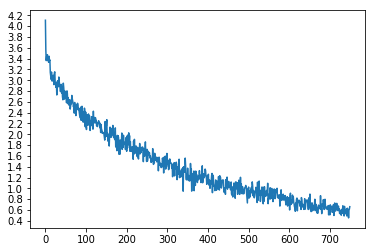

In [104]:
use_attention=False
hidden_size = 256
T_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
T_decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

plot_losses = trainIters(T_encoder, T_decoder, 75000, use_attention, print_every=5000)

In [126]:
use_attention=False
evaluateRandomly(T_encoder, T_decoder, use_attention)

> tu es la plus mignonne .
= you re the sweetest .
< you re the sweetest . <EOS>

> tu es fort craintive .
= you re very timid .
< you re very timid . <EOS>

> je garde la maison .
= i m housesitting .
< i m housesitting . <EOS>

> elle est fauchee .
= she is hard up for money .
< she is hard up hard . <EOS>

> t es une chouette gonzesse .
= you are a good person .
< you re a good person . <EOS>

> vous m intimidez toujours .
= i m still intimidated by you .
< i m still intimidated by you . <EOS>

> nous n en sommes pas encore convaincus .
= we re not convinced yet .
< we re not convinced yet . <EOS>

> tu es arrogante .
= you re arrogant .
< you re arrogant . <EOS>

> elles attendent toutes .
= they re all waiting .
< they re all waiting . <EOS>

> elle me parla en espagnol .
= she spoke to me in spanish .
< she spoke me me in . <EOS>



torch.Size([4489, 256])
torch.Size([768, 256])
torch.Size([768, 256])
torch.Size([768])
torch.Size([768])


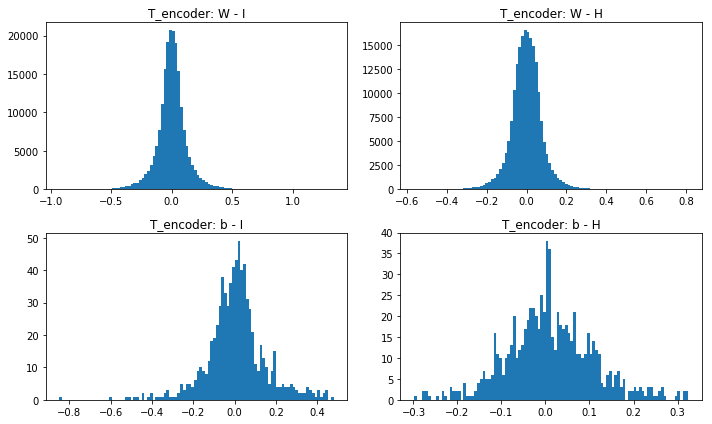

In [127]:
weights = []
for w in T_encoder.parameters():
    print (w.shape)
    weights.append(w.data.cpu().numpy())
    
f, (a0, a1) = plt.subplots(2,2,figsize=(10, 6))
a0[0].hist(weights[1].reshape(-1), 100)[-1]; a0[0].set_title('T_encoder: W - I')
a0[1].hist(weights[2].reshape(-1), 100)[-1]; a0[1].set_title('T_encoder: W - H')
a1[0].hist(weights[3].reshape(-1), 100)[-1]; a1[0].set_title('T_encoder: b - I')
a1[1].hist(weights[4].reshape(-1), 100)[-1]; a1[1].set_title('T_encoder: b - H')
f.tight_layout()

torch.Size([2925, 256])
torch.Size([768, 256])
torch.Size([768, 256])
torch.Size([768])
torch.Size([768])
torch.Size([2925, 256])
torch.Size([2925])


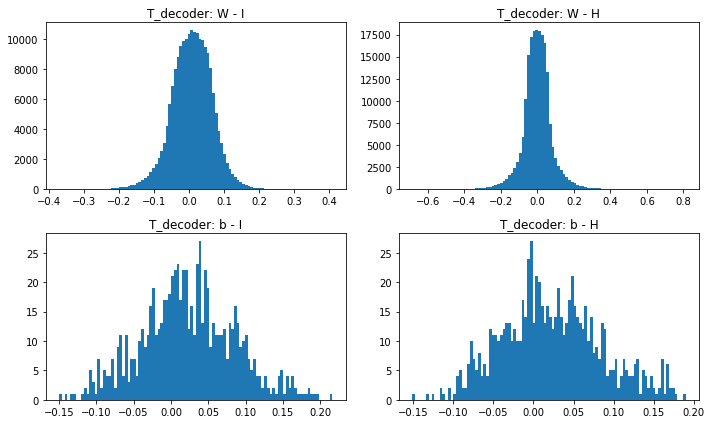

In [128]:
weights = []
for w in T_decoder.parameters():
    print (w.shape)
    weights.append(w.data.cpu().numpy())
    
f, (a0, a1) = plt.subplots(2,2,figsize=(10, 6))
a0[0].hist(weights[1].reshape(-1), 100)[-1]; a0[0].set_title('T_decoder: W - I')
a0[1].hist(weights[2].reshape(-1), 100)[-1]; a0[1].set_title('T_decoder: W - H')
a1[0].hist(weights[3].reshape(-1), 100)[-1]; a1[0].set_title('T_decoder: b - I')
a1[1].hist(weights[4].reshape(-1), 100)[-1]; a1[1].set_title('T_decoder: b - H')
f.tight_layout()

# Model II: Torch Attention

In [105]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        #print (output.shape, hidden.shape): torch.Size([1, 1, 256]) torch.Size([1, 1, 256])

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

1m 29s (- 20m 53s) (5000 6%) 2.9835
2m 57s (- 19m 11s) (10000 13%) 2.4313
4m 25s (- 17m 42s) (15000 20%) 2.1211
5m 54s (- 16m 14s) (20000 26%) 1.8779
7m 23s (- 14m 47s) (25000 33%) 1.6633
8m 53s (- 13m 19s) (30000 40%) 1.5091
10m 22s (- 11m 51s) (35000 46%) 1.3756
11m 52s (- 10m 23s) (40000 53%) 1.2032
13m 22s (- 8m 55s) (45000 60%) 1.1113
14m 52s (- 7m 26s) (50000 66%) 1.0408
16m 22s (- 5m 57s) (55000 73%) 0.9499
17m 52s (- 4m 28s) (60000 80%) 0.8731
19m 22s (- 2m 58s) (65000 86%) 0.7990
20m 52s (- 1m 29s) (70000 93%) 0.7401
22m 22s (- 0m 0s) (75000 100%) 0.6838


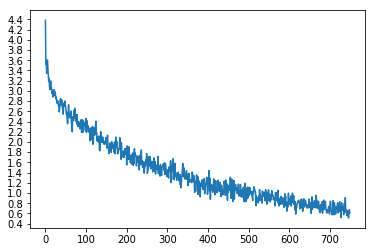

In [106]:
use_attention=True
hidden_size = 256
T_attnEncoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
T_attnDecoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

plot_losses = trainIters(T_attnEncoder, T_attnDecoder, 75000, use_attention, print_every=5000)

In [129]:
use_attention=True
evaluateRandomly(T_attnEncoder, T_attnDecoder, use_attention)

> je suis cuisinier .
= i am a cook .
< i am a cook . <EOS>

> je suis toujours inquiet .
= i m still concerned .
< i m still happy . <EOS>

> nous sommes une grande famille .
= we re a big family .
< we are a family family . <EOS>

> j y travaille .
= i m working on it .
< i m working on it <EOS>

> je suis toujours occupe .
= i m still busy .
< i m all busy . <EOS>

> elle n est pas tres douee au tennis .
= she is rather poor at tennis .
< she s not very tennis tennis . <EOS>

> vous etes tres religieux n est ce pas ?
= you re very religious aren t you ?
< you re very religious aren t you ? <EOS>

> il est jeune et attirant .
= he s young and attractive .
< he s young and attractive . <EOS>

> je n ai pas honte de vous dire .
= i m not ashamed to tell you .
< i m not ashamed to tell you . <EOS>

> je suis tellement gene que je veux mourir .
= i m so embarrassed i want to die .
< i m so embarrassed i want to . <EOS>



torch.Size([4489, 256])
torch.Size([768, 256])
torch.Size([768, 256])
torch.Size([768])
torch.Size([768])


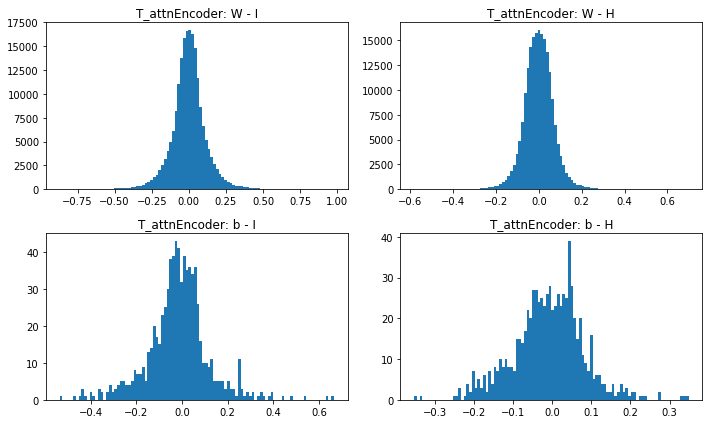

In [130]:
weights = []
for w in T_attnEncoder.parameters():
    print (w.shape)
    weights.append(w.data.cpu().numpy())
    
f, (a0, a1) = plt.subplots(2,2,figsize=(10, 6))
a0[0].hist(weights[1].reshape(-1), 100)[-1]; a0[0].set_title('T_attnEncoder: W - I')
a0[1].hist(weights[2].reshape(-1), 100)[-1]; a0[1].set_title('T_attnEncoder: W - H')
a1[0].hist(weights[3].reshape(-1), 100)[-1]; a1[0].set_title('T_attnEncoder: b - I')
a1[1].hist(weights[4].reshape(-1), 100)[-1]; a1[1].set_title('T_attnEncoder: b - H')
f.tight_layout()

torch.Size([2925, 256])
torch.Size([10, 512])
torch.Size([10])
torch.Size([256, 512])
torch.Size([256])
torch.Size([768, 256])
torch.Size([768, 256])
torch.Size([768])
torch.Size([768])
torch.Size([2925, 256])
torch.Size([2925])


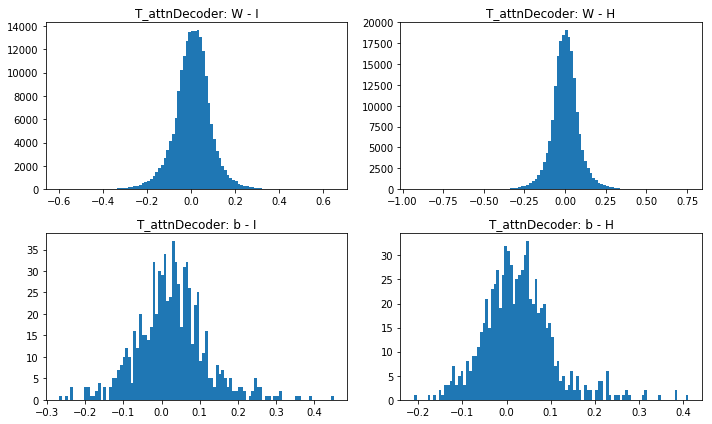

In [133]:
weights = []
for w in T_attnDecoder.parameters():
    print (w.shape)
    weights.append(w.data.cpu().numpy())
    
f, (a0, a1) = plt.subplots(2,2,figsize=(10, 6))
a0[0].hist(weights[5].reshape(-1), 100)[-1]; a0[0].set_title('T_attnDecoder: W - I')
a0[1].hist(weights[6].reshape(-1), 100)[-1]; a0[1].set_title('T_attnDecoder: W - H')
a1[0].hist(weights[7].reshape(-1), 100)[-1]; a1[0].set_title('T_attnDecoder: b - I')
a1[1].hist(weights[8].reshape(-1), 100)[-1]; a1[1].set_title('T_attnDecoder: b - H')
f.tight_layout()

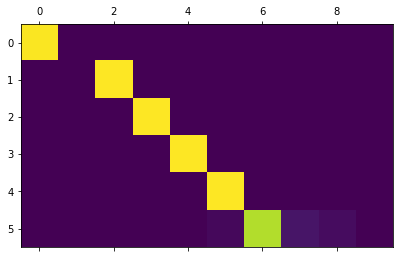

In [145]:
use_attention = True
output_words, attentions = evaluate(
    T_attnEncoder, T_attnDecoder, "je suis trop froid .", use_attention)
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she is five years younger than me <EOS>


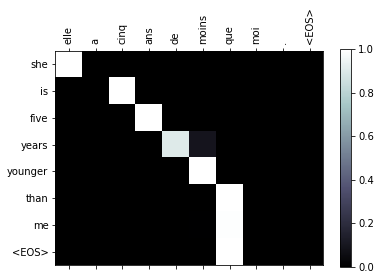

input = elle est trop petit .
output = she s too slow . <EOS>


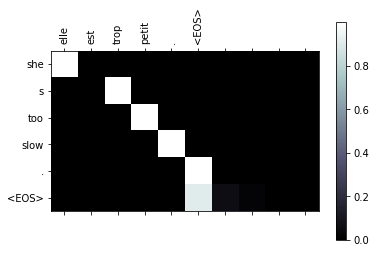

input = je ne crains pas de mourir .
output = i m not dying to die . <EOS>


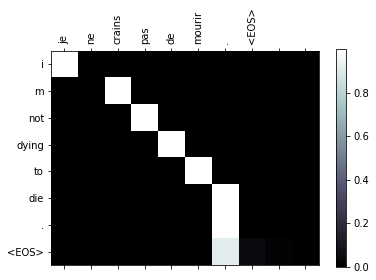

input = c est un jeune directeur plein de talent .
output = he s a talented young young . <EOS>


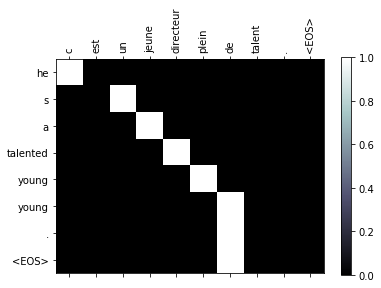

In [146]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        T_attnEncoder, T_attnDecoder, input_sentence, True)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

# Model III: Custom RNN

In [107]:
class CustomEncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomEncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        # GRU. W; b
        self.Wz = _getGRUWeights(hidden_size, hidden_size); self.Wbz = _getGRUbias(hidden_size)
        self.Wr = _getGRUWeights(hidden_size, hidden_size); self.Wbr = _getGRUbias(hidden_size)
        self.Wh = _getGRUWeights(hidden_size, hidden_size); self.Wbh = _getGRUbias(hidden_size)
        self.Uz = _getGRUWeights(hidden_size, hidden_size); self.Ubz = _getGRUbias(hidden_size)
        self.Ur = _getGRUWeights(hidden_size, hidden_size); self.Ubr = _getGRUbias(hidden_size)
        self.Uh = _getGRUWeights(hidden_size, hidden_size); self.Ubh = _getGRUbias(hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        
        # GRU
        zt = F.sigmoid(matmul(output, self.Wz) + self.Wbz + matmul(hidden, self.Uz) + self.Ubz)
        rt = F.sigmoid(matmul(output, self.Wr) + self.Wbr + matmul(hidden, self.Ur) + self.Ubr)
        htt= F.tanh(matmul(output, self.Wh) + self.Wbh + matmul(rt*hidden, self.Uh) + self.Ubh)
        ht = zt*hidden + (1-zt)*htt
        
        hidden = ht
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [109]:
class CustomDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(CustomDecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        
        # GRU. W; b
        self.Wz = _getGRUWeights(hidden_size, hidden_size); self.Wbz = _getGRUbias(hidden_size)
        self.Wr = _getGRUWeights(hidden_size, hidden_size); self.Wbr = _getGRUbias(hidden_size)
        self.Wh = _getGRUWeights(hidden_size, hidden_size); self.Wbh = _getGRUbias(hidden_size)
        self.Uz = _getGRUWeights(hidden_size, hidden_size); self.Ubz = _getGRUbias(hidden_size)
        self.Ur = _getGRUWeights(hidden_size, hidden_size); self.Ubr = _getGRUbias(hidden_size)
        self.Uh = _getGRUWeights(hidden_size, hidden_size); self.Ubh = _getGRUbias(hidden_size)
        
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        
        # GRU
        zt = F.sigmoid(matmul(output, self.Wz) + self.Wbz + matmul(hidden, self.Uz) + self.Ubz)
        rt = F.sigmoid(matmul(output, self.Wr) + self.Wbr + matmul(hidden, self.Ur) + self.Ubr)
        htt= F.tanh(matmul(output, self.Wh) + self.Wbh + matmul(rt*hidden, self.Uh) + self.Ubh)
        ht = zt*hidden + (1-zt)*htt
        
        hidden = ht
        output = ht
        # print (output.shape, hidden.shape) #torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

1m 17s (- 18m 7s) (5000 6%) 3.3181
2m 32s (- 16m 31s) (10000 13%) 3.0778
3m 48s (- 15m 13s) (15000 20%) 2.9722
5m 4s (- 13m 56s) (20000 26%) 2.8527
6m 20s (- 12m 41s) (25000 33%) 2.8043
7m 37s (- 11m 26s) (30000 40%) 2.7788
8m 54s (- 10m 10s) (35000 46%) 2.7398
10m 12s (- 8m 55s) (40000 53%) 2.7328
11m 29s (- 7m 39s) (45000 60%) 2.6725
12m 47s (- 6m 23s) (50000 66%) 2.6188
14m 5s (- 5m 7s) (55000 73%) 2.6402
15m 23s (- 3m 50s) (60000 80%) 2.5961
16m 41s (- 2m 34s) (65000 86%) 2.5791
17m 59s (- 1m 17s) (70000 93%) 2.5382
19m 17s (- 0m 0s) (75000 100%) 2.5144


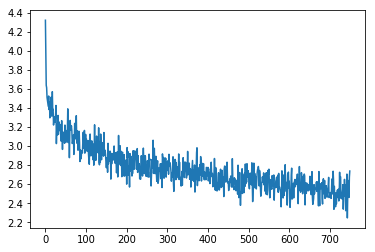

In [110]:
use_attention=False
hidden_size = 256
custom_encoder = CustomEncoderRNN(input_lang.n_words, hidden_size).to(device)
custom_decoder = CustomDecoderRNN(hidden_size, output_lang.n_words).to(device)

plot_losses = trainIters(custom_encoder, custom_decoder, 75000, use_attention, print_every=5000)

In [134]:
use_attention=False
evaluateRandomly(custom_encoder, custom_decoder, use_attention)

> nous vous protegeons .
= we re protecting you .
< you re my . . <EOS>

> tu es fort courageux .
= you re very brave .
< you re my . . <EOS>

> tu es fou .
= you are crazy .
< you re very . . <EOS>

> elle est toujours en quete de compliments .
= she is always fishing for compliments .
< she is a of . . . <EOS>

> je suis pret pour le combat .
= i m ready for the fight .
< i m the to the . . . . <EOS>

> je suis un etudiant de cette ecole .
= i am a student of this school .
< i m sure of of . . . . <EOS>

> je suis tellement rassasie .
= i m so full .
< i m sure . . . <EOS>

> ils sont propres .
= they re clean .
< they re all . . <EOS>

> elle le dit avec un sourire .
= she said with a smile .
< she s a for as . . . . <EOS>

> vous etes cerne .
= you re surrounded .
< you re very . <EOS>



In [112]:
def _getOneDimW(w):
    return w.data.cpu().numpy().reshape(-1)

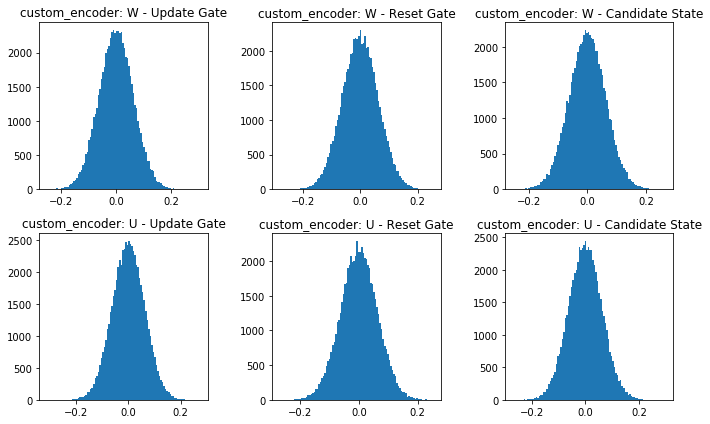

In [135]:
f, (a0, a1) = plt.subplots(2,3,figsize=(10, 6))
a0[0].hist(_getOneDimW(custom_encoder.Wz), 100)[-1]; a0[0].set_title('custom_encoder: W - Update Gate')
a0[1].hist(_getOneDimW(custom_encoder.Wr), 100)[-1]; a0[1].set_title('custom_encoder: W - Reset Gate')
a0[2].hist(_getOneDimW(custom_encoder.Wh), 100)[-1]; a0[2].set_title('custom_encoder: W - Candidate State')
a1[0].hist(_getOneDimW(custom_encoder.Uz), 100)[-1]; a1[0].set_title('custom_encoder: U - Update Gate')
a1[1].hist(_getOneDimW(custom_encoder.Ur), 100)[-1]; a1[1].set_title('custom_encoder: U - Reset Gate')
a1[2].hist(_getOneDimW(custom_encoder.Uh), 100)[-1]; a1[2].set_title('custom_encoder: U - Candidate State')
f.tight_layout()

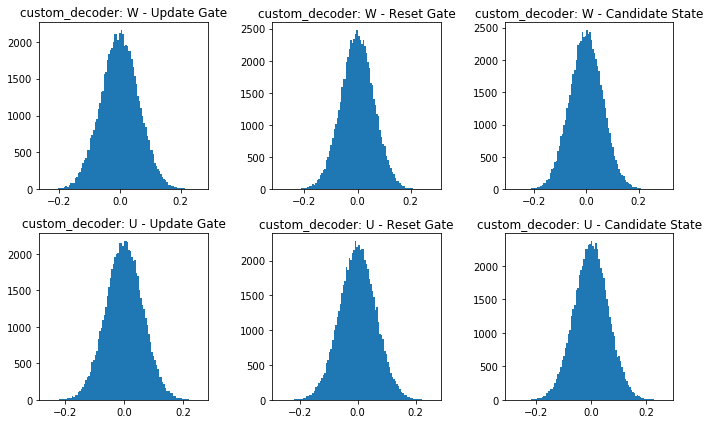

In [136]:
f, (a0, a1) = plt.subplots(2,3,figsize=(10, 6))
a0[0].hist(_getOneDimW(custom_decoder.Wz), 100)[-1]; a0[0].set_title('custom_decoder: W - Update Gate')
a0[1].hist(_getOneDimW(custom_decoder.Wr), 100)[-1]; a0[1].set_title('custom_decoder: W - Reset Gate')
a0[2].hist(_getOneDimW(custom_decoder.Wh), 100)[-1]; a0[2].set_title('custom_decoder: W - Candidate State')
a1[0].hist(_getOneDimW(custom_decoder.Uz), 100)[-1]; a1[0].set_title('custom_decoder: U - Update Gate')
a1[1].hist(_getOneDimW(custom_decoder.Ur), 100)[-1]; a1[1].set_title('custom_decoder: U - Reset Gate')
a1[2].hist(_getOneDimW(custom_decoder.Uh), 100)[-1]; a1[2].set_title('custom_decoder: U - Candidate State')
f.tight_layout()

# Model IV: Custom Attention

In [82]:
class CustomEncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomEncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        # GRU. W; b
        self.Wz = _getGRUWeights(hidden_size, hidden_size); self.Wbz = _getGRUbias(hidden_size)
        self.Wr = _getGRUWeights(hidden_size, hidden_size); self.Wbr = _getGRUbias(hidden_size)
        self.Wh = _getGRUWeights(hidden_size, hidden_size); self.Wbh = _getGRUbias(hidden_size)
        self.Uz = _getGRUWeights(hidden_size, hidden_size); self.Ubz = _getGRUbias(hidden_size)
        self.Ur = _getGRUWeights(hidden_size, hidden_size); self.Ubr = _getGRUbias(hidden_size)
        self.Uh = _getGRUWeights(hidden_size, hidden_size); self.Ubh = _getGRUbias(hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        
        # GRU
        zt = F.sigmoid(matmul(output, self.Wz) + self.Wbz + matmul(hidden, self.Uz) + self.Ubz)
        rt = F.sigmoid(matmul(output, self.Wr) + self.Wbr + matmul(hidden, self.Ur) + self.Ubr)
        htt= F.tanh(matmul(output, self.Wh) + self.Wbh + matmul(rt*hidden, self.Uh) + self.Ubh)
        ht = zt*hidden + (1-zt)*htt
        
        hidden = ht
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [123]:
class CustomAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(CustomAttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        # GRU. W; b
        self.Wz = _getGRUWeights(hidden_size, hidden_size); self.Wbz = _getGRUbias(hidden_size)
        self.Wr = _getGRUWeights(hidden_size, hidden_size); self.Wbr = _getGRUbias(hidden_size)
        self.Wh = _getGRUWeights(hidden_size, hidden_size); self.Wbh = _getGRUbias(hidden_size)
        self.Uz = _getGRUWeights(hidden_size, hidden_size); self.Ubz = _getGRUbias(hidden_size)
        self.Ur = _getGRUWeights(hidden_size, hidden_size); self.Ubr = _getGRUbias(hidden_size)
        self.Uh = _getGRUWeights(hidden_size, hidden_size); self.Ubh = _getGRUbias(hidden_size)
        
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        
        # GRU
        zt = F.sigmoid(matmul(output, self.Wz) + self.Wbz + matmul(hidden, self.Uz) + self.Ubz)
        rt = F.sigmoid(matmul(output, self.Wr) + self.Wbr + matmul(hidden, self.Ur) + self.Ubr)
        htt= F.tanh(matmul(output, self.Wh) + self.Wbh + matmul(rt*hidden, self.Uh) + self.Ubh)
        ht = zt*hidden + (1-zt)*htt
        
        output = ht
        hidden = ht
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

1m 38s (- 22m 56s) (5000 6%) 2.9775
3m 13s (- 21m 0s) (10000 13%) 2.7880
4m 50s (- 19m 20s) (15000 20%) 2.6846
6m 25s (- 17m 41s) (20000 26%) 2.5912
8m 1s (- 16m 3s) (25000 33%) 2.4710
9m 37s (- 14m 26s) (30000 40%) 2.4436
11m 13s (- 12m 49s) (35000 46%) 2.3843
12m 50s (- 11m 13s) (40000 53%) 2.3462
14m 26s (- 9m 37s) (45000 60%) 2.2789
16m 3s (- 8m 1s) (50000 66%) 2.2461
17m 44s (- 6m 27s) (55000 73%) 2.1915
19m 27s (- 4m 51s) (60000 80%) 2.1165
21m 10s (- 3m 15s) (65000 86%) 2.0996
22m 54s (- 1m 38s) (70000 93%) 2.0641
24m 37s (- 0m 0s) (75000 100%) 2.0606


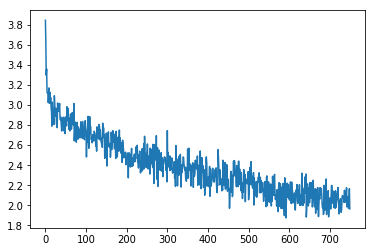

In [137]:
use_attention=True
hidden_size = 256
custom_attnEncoder = CustomEncoderRNN(input_lang.n_words, hidden_size).to(device)
custom_attnDecoder = CustomAttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

plot_losses = trainIters(custom_attnEncoder, custom_attnDecoder, 75000, use_attention, print_every=5000)

In [138]:
use_attention=True
evaluateRandomly(custom_attnEncoder, custom_attnDecoder, use_attention)

> je suis de ton cote .
= i m by your side .
< i am a little . <EOS>

> je suis plus elegant que vous .
= i m smarter than you .
< i am as than you . <EOS>

> je ne suis pas ton ennemie .
= i m not your enemy .
< i m not your enemy . <EOS>

> je suis une artiste .
= i m an artist .
< i am a a . <EOS>

> enchante de faire votre connaissance .
= i m pleased to meet you .
< i m sorry to . . <EOS>

> je suis completement pete .
= i m completely wrecked .
< i am a . . <EOS>

> tu es sauve .
= you re safe .
< you re very . <EOS>

> ils sont de notre force .
= they are as strong as us .
< they re back behind you . <EOS>

> je suis coincee dans un embouteillage .
= i m stuck in a traffic jam .
< i am a a a little . <EOS>

> ils sont tres compatibles .
= they are very compatible .
< they re very cheerful . <EOS>



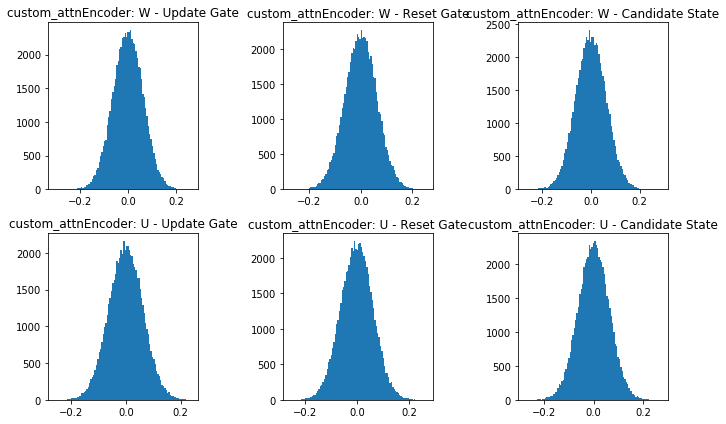

In [139]:
f, (a0, a1) = plt.subplots(2,3,figsize=(10, 6))
a0[0].hist(_getOneDimW(custom_attnEncoder.Wz), 100)[-1]; a0[0].set_title('custom_attnEncoder: W - Update Gate')
a0[1].hist(_getOneDimW(custom_attnEncoder.Wr), 100)[-1]; a0[1].set_title('custom_attnEncoder: W - Reset Gate')
a0[2].hist(_getOneDimW(custom_attnEncoder.Wh), 100)[-1]; a0[2].set_title('custom_attnEncoder: W - Candidate State')
a1[0].hist(_getOneDimW(custom_attnEncoder.Uz), 100)[-1]; a1[0].set_title('custom_attnEncoder: U - Update Gate')
a1[1].hist(_getOneDimW(custom_attnEncoder.Ur), 100)[-1]; a1[1].set_title('custom_attnEncoder: U - Reset Gate')
a1[2].hist(_getOneDimW(custom_attnEncoder.Uh), 100)[-1]; a1[2].set_title('custom_attnEncoder: U - Candidate State')
f.tight_layout()

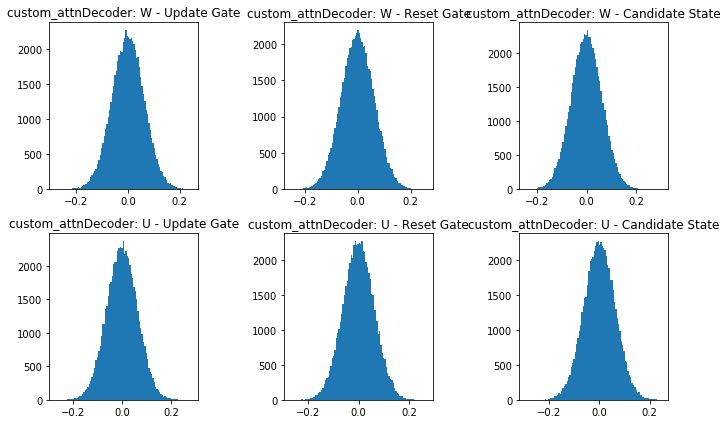

In [140]:
f, (a0, a1) = plt.subplots(2,3,figsize=(10, 6))
a0[0].hist(_getOneDimW(custom_attnDecoder.Wz), 100)[-1]; a0[0].set_title('custom_attnDecoder: W - Update Gate')
a0[1].hist(_getOneDimW(custom_attnDecoder.Wr), 100)[-1]; a0[1].set_title('custom_attnDecoder: W - Reset Gate')
a0[2].hist(_getOneDimW(custom_attnDecoder.Wh), 100)[-1]; a0[2].set_title('custom_attnDecoder: W - Candidate State')
a1[0].hist(_getOneDimW(custom_attnDecoder.Uz), 100)[-1]; a1[0].set_title('custom_attnDecoder: U - Update Gate')
a1[1].hist(_getOneDimW(custom_attnDecoder.Ur), 100)[-1]; a1[1].set_title('custom_attnDecoder: U - Reset Gate')
a1[2].hist(_getOneDimW(custom_attnDecoder.Uh), 100)[-1]; a1[2].set_title('custom_attnDecoder: U - Candidate State')
f.tight_layout()

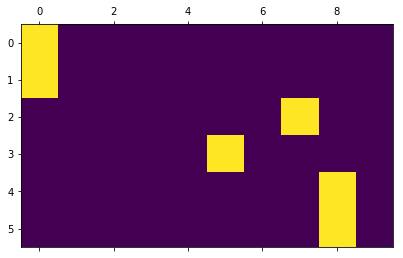

In [143]:
use_attention = True
output_words, attentions = evaluate(
    custom_attnEncoder, custom_attnDecoder, "je suis trop froid .", use_attention)
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she is six years me me . <EOS>


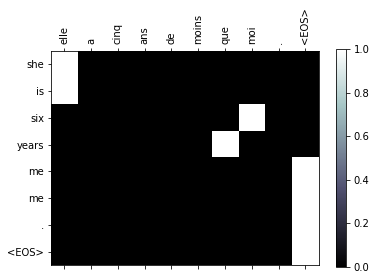

input = elle est trop petit .
output = she is a . . <EOS>


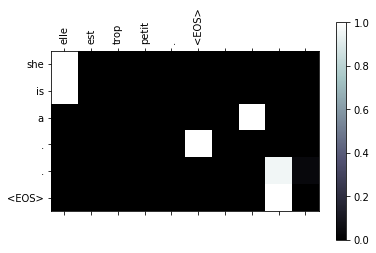

input = je ne crains pas de mourir .
output = i m not scared . . <EOS>


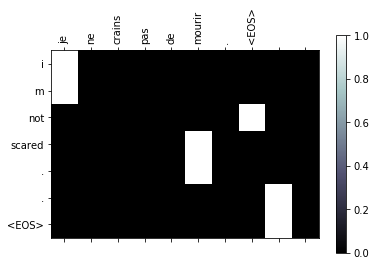

input = c est un jeune directeur plein de talent .
output = he is a a . of . <EOS>


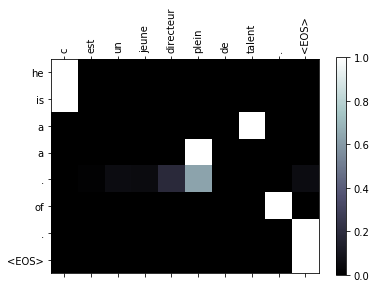

In [144]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        custom_attnEncoder, custom_attnDecoder, input_sentence, True)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")